# Построение моделей для решения задачи классификации (бинарная)

## Импорт необходимых библиотек

In [1]:
import numpy as np
import pandas as pd
import json
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score, roc_curve, auc
from scipy.stats import loguniform, uniform, randint

Загрузка датасета

Целевой признак - bomb_planted

In [2]:
data = pd.read_csv('csgo_filtred.csv')

y = data['bomb_planted']
X = data.drop(columns=['bomb_planted'], axis=1)

## Проверка баланса классов

In [3]:
X.head()

,time_left,ct_score,t_score,map,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,t_helmets,ct_defuse_kits,ct_players_alive,t_players_alive,health_lead,armor_lead,money_lead,helmets_lead,players_alive_lead
0,175.00,0,0,de_dust2,500,500,0,0,4000,4000,0,0,0,5,5,2,2,2,2,2
1,156.03,0,0,de_dust2,500,500,400,300,600,650,0,0,1,5,5,2,0,1,2,2
2,96.03,0,0,de_dust2,391,400,294,200,750,500,0,0,1,4,4,1,0,0,2,2
3,76.03,0,0,de_dust2,391,400,294,200,750,500,0,0,1,4,4,1,0,0,2,2
4,174.97,1,0,de_dust2,500,500,192,0,18350,10750,0,0,1,5,5,2,0,0,2,2


<Axes: ylabel='bomb_planted'>

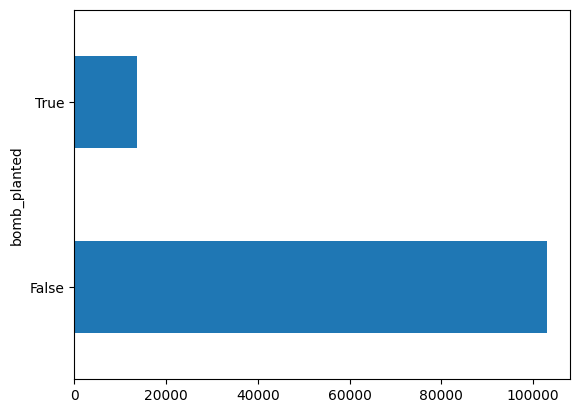

In [4]:
y.value_counts().plot.barh()

In [5]:
y.value_counts()

bomb_planted
False    102945
True      13684
Name: count, dtype: int64

Видно, что классы максимально несбалансированы, количество класса false превосходит класс true более чем в 5 раз.

Для балансировки буду использовать метод SMOTE, он создаёт дополнительные точки для минаритарного класса, основываясь на уже существующих точках.

Но для начала преобразую переменные признака map в числовые.

In [6]:
X['map'].value_counts()

map
de_inferno     22806
de_dust2       21040
de_nuke        17879
de_mirage      17641
de_overpass    13375
de_train       12800
de_vertigo     10733
unknown          211
de_cache         144
Name: count, dtype: int64

In [7]:
X['map'] = X['map'].str.strip().str.lower()

In [8]:
mapping = {
    'de_inferno': 1,
    'de_dust2': 2,
    'de_nuke': 3,
    'de_mirage': 4,
    'de_overpass': 5,
    'de_train': 6,
    'de_vertigo': 7,
    'unknown': 8,
    'de_cache': 9
}

X['map'] = X['map'].map(mapping)
X['map'].value_counts()

map
1    22806
2    21040
3    17879
4    17641
5    13375
6    12800
7    10733
8      211
9      144
Name: count, dtype: int64

In [9]:
oversample = SMOTE()
transformed_X, tranformed_y = oversample.fit_resample(X, y)

In [10]:
print(f'OLD: {y.value_counts()}')
print()
print(f'NEW: {tranformed_y.value_counts()}')

OLD: bomb_planted
False    102945
True      13684
Name: count, dtype: int64

NEW: bomb_planted
False    102945
True     102945
Name: count, dtype: int64


In [11]:
X, y = transformed_X, tranformed_y

In [12]:
X.duplicated().sum()

np.int64(0)

Как можно увидеть балансировка по классам получилась успешной, теперь мы имеем два класса с одинаковым количеством точек.

## Разделение на тренировочную и тестовую выборки

In [13]:
# Метод train_test_split с использованием stratify

X = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.5, stratify=y, test_size=0.1)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((102945, 20), (102945,), (20589, 20), (20589,))

In [14]:
X_train_search, X_test_search, y_train_search, y_test_search = train_test_split(X, y, random_state=42, train_size=0.05, stratify=y, test_size=0.01)
X_train_search.shape, y_train_search.shape, X_test_search.shape, y_test_search.shape

((10294, 20), (10294,), (2059, 20), (2059,))

In [15]:
# KFold

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [16]:
# Маштабирование

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train_search = scaler.fit_transform(X_train_search)
X_test_search = scaler.transform(X_test_search)

## Вычисление лучший гиперпараметров для моделей

По заданию необходимо использовать такие модели классификации как:

- `Logistic Regression`
- `kNN`
- `Naive Bayes`
- `SVM` (в том числе ядерные функции (Linear Kernel, Polynomial Kernel, RBF Kernel, Sigmoid Kernel, Exponential Kernel))

Для начала найду для всех этих моделей лучшие гиперпараметры

`ВАЖНО!` Датасет после балансировки классов состоит из 200тыс объектов, искать гиперпараметры на таком объёмы это потрать дни, поэтому в самом начале специально были созданы выборки по 10тыс объектов для поиска гиперпараметров, далее применяя наиденные гиперпараметры в моделях, буду обучать их на 100тыс объектах.

Сохранение словаря как json файла, чтобы не вычислять его повторно

In [17]:
with open('best_params.json', 'r') as f:
    best_params = json.load(f)

## Обучение моделей

In [18]:
def metrics(pred_array, true_array=y_test,):
    print(f'F1: {f1_score(true_array, pred_array)}')
    print(f'accuracy: {accuracy_score(true_array, pred_array)}')
    print(f'precision: {precision_score(true_array, pred_array)}')
    print(f'recall: {recall_score(true_array, pred_array)}')
    print(f'roc_auc_score: {roc_auc_score(true_array, pred_array)}')

Logistic Regression

In [19]:
model_lr = LogisticRegression(
    max_iter=10000, 
    penalty=best_params['LogisticRegression']['GridSearchCV']['params']['penalty'],
    solver=best_params['LogisticRegression']['GridSearchCV']['params']['solver'],
    tol=best_params['LogisticRegression']['GridSearchCV']['params']['tol'],
    C=best_params['LogisticRegression']['GridSearchCV']['params']['C']
    )
# Hold-out
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)
metrics(y_pred_lr)
# CV
scores_lr = cross_val_score(model_lr, X_train, y_train, cv=kf, scoring='accuracy')
print(f'Оценка кросс-валидации: {scores_lr.mean()}')

F1: 0.9541476407914764
accuracy: 0.9531788819272426
precision: 0.934762348555452
recall: 0.9743539926170585
roc_auc_score: 0.953179910344469
Оценка кросс-валидации: 0.950604691825732


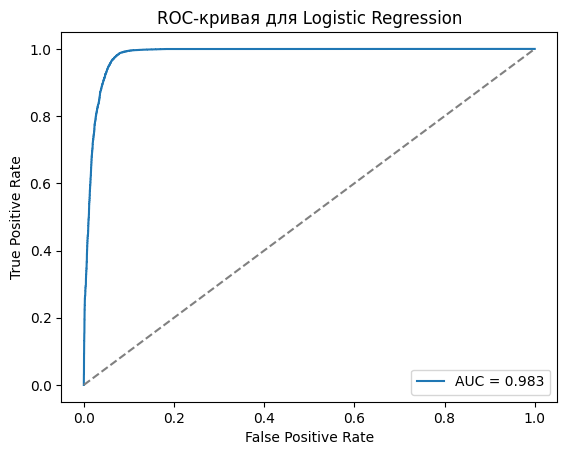

In [20]:
y_prob_lr = model_lr.predict_proba(X_test)[:, 1]

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure()
plt.plot(fpr_lr, tpr_lr, label=f'AUC = {roc_auc_lr:.3f}')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая для Logistic Regression')
plt.legend(loc='lower right')
plt.show()

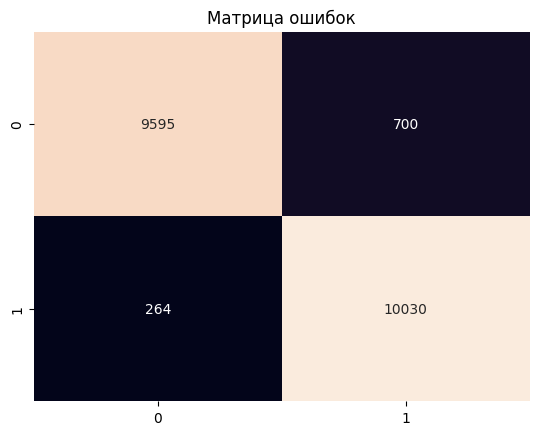

In [21]:
cm_lr = confusion_matrix(y_test, y_pred_lr)

plt.figure()
sns.heatmap(cm_lr, annot=True, fmt='d', cbar=False)
plt.title('Матрица ошибок')
plt.show()

In [22]:
model_lr = joblib.load(r'models\logistic_regression_model')

kNN

In [23]:
model_knn = KNeighborsClassifier(
    n_neighbors=best_params['kNN']['GridSearchCV']['params']['n_neighbors'],
    weights=best_params['kNN']['GridSearchCV']['params']['weights'],
    metric=best_params['kNN']['GridSearchCV']['params']['metric']
)
# Hold-out
model_knn.fit(X_train, y_train)
y_pred_knn = model_knn.predict(X_test)
metrics(y_pred_knn)
# CV
scores_knn = cross_val_score(model_knn, X_train, y_train, cv=kf, scoring='accuracy')
print(f'Оценка кросс-валидации: {scores_knn.mean()}')

F1: 0.9517085569048291
accuracy: 0.950167565204721
precision: 0.9231190650109569
recall: 0.9821255100058286
roc_auc_score: 0.9501691173147162
Оценка кросс-валидации: 0.945582592646559


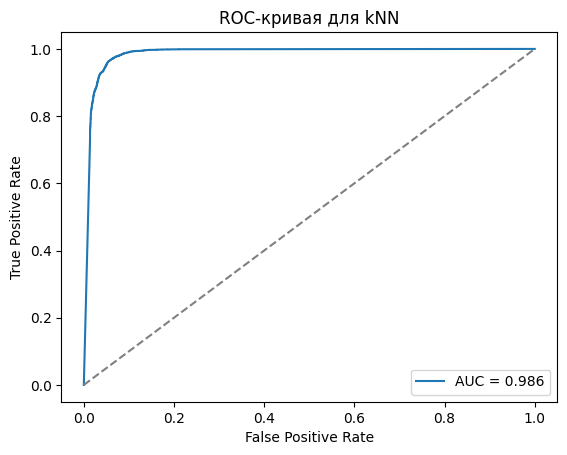

In [24]:
y_prob_knn = model_knn.predict_proba(X_test)[:, 1]

fpr_knn, tpr_knn, _ = roc_curve(y_test, y_prob_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)

plt.figure()
plt.plot(fpr_knn, tpr_knn, label=f'AUC = {roc_auc_knn:.3f}')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая для kNN')
plt.legend(loc='lower right')
plt.show()

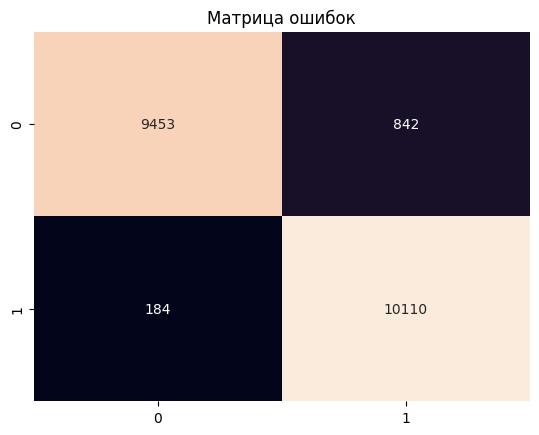

In [ ]:
cm_knn = confusion_matrix(y_test, y_pred_knn)

plt.figure()
sns.heatmap(cm_knn, annot=True, fmt='d', cbar=False)
plt.title('Матрица ошибок')
plt.show()

In [26]:
# Сохранение модели

joblib.dump(model_knn, "knn_model")

['knn_model']

In [27]:
model_knn = joblib.load(r'models\knn_model')

Своя реализация kNN размер выборок по 1000 объектов

In [65]:
X_train_1000, X_test_1000, y_train_1000, y_test_1000 = train_test_split(X, y, random_state=42, train_size=0.005, stratify=y, test_size=0.0025)
X_train_1000.shape, y_train_1000.shape, X_test_1000.shape, y_test_1000.shape

((1029, 20), (1029,), (515, 20), (515,))

In [68]:
from kNN import kNN

model_knn_own = kNN()
model_knn_own.fit(X_train=X_train_1000, y_train=y_train_1000)
y_pred_knn_own = model_knn_own.predict(X_test_1000)
metrics(true_array=y_test_1000, pred_array=y_pred_knn_own)

F1: 0.9087523277467412
accuracy: 0.9048543689320389
precision: 0.8714285714285714
recall: 0.9494163424124513
roc_auc_score: 0.9049407293457605


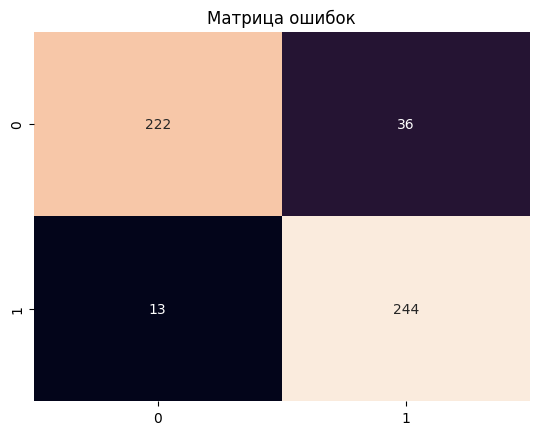

In [70]:
cm_knn_own = confusion_matrix(y_test_1000, y_pred_knn_own)

plt.figure()
sns.heatmap(cm_knn_own, annot=True, fmt='d', cbar=False)
plt.title('Матрица ошибок')
plt.show()

Naive Bayes

In [28]:
model_nb = GaussianNB(
    var_smoothing=1e-09
)
# Hold-out
model_nb.fit(X_train, y_train)
y_pred_nb = model_nb.predict(X_test)
metrics(y_pred_nb)
# CV
scores_nb = cross_val_score(model_nb, X_train, y_train, cv=kf, scoring='accuracy')
print(f'Оценка кросс-валидации: {scores_nb.mean()}')

F1: 0.919236276849642
accuracy: 0.9178201952498907
precision: 0.9036223723723724
recall: 0.9353992617058481
roc_auc_score: 0.9178210490170814
Оценка кросс-валидации: 0.9185195978435086


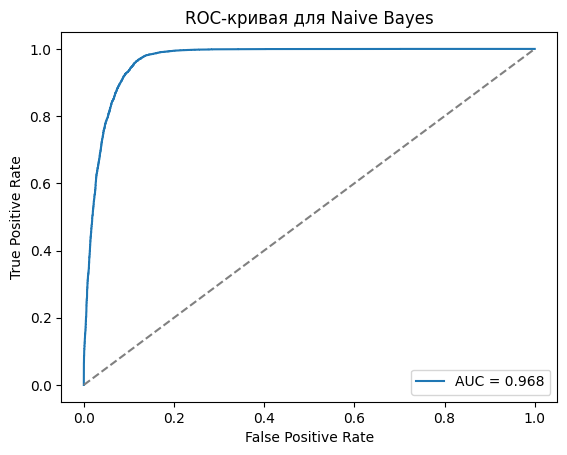

In [29]:
y_prob_nb = model_nb.predict_proba(X_test)[:, 1]

fpr_nb, tpr_nb, _ = roc_curve(y_test, y_prob_nb)
roc_auc_nb = auc(fpr_nb, tpr_nb)

plt.figure()
plt.plot(fpr_nb, tpr_nb, label=f'AUC = {roc_auc_nb:.3f}')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая для Naive Bayes')
plt.legend(loc='lower right')
plt.show()

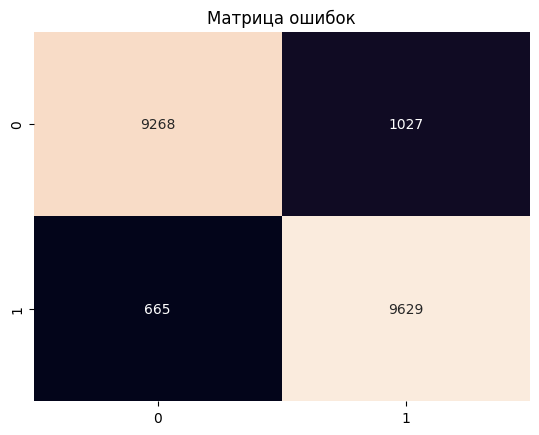

In [30]:
cm_nb = confusion_matrix(y_test, y_pred_nb)

plt.figure()
sns.heatmap(cm_nb, annot=True, fmt='d', cbar=False)
plt.title('Матрица ошибок')
plt.show()

In [31]:
model_nb = joblib.load(r'models\naive_bayes_model')

SVC(rbf) size 10000 objects

In [32]:
model_svc_rbf = SVC(
    C=best_params['SVM']['GridSearchCV']['params']['C'],
    gamma=best_params['SVM']['GridSearchCV']['params']['gamma'],
    kernel='rbf',
    probability=True
)
# Hold-out
model_svc_rbf.fit(X_train_search, y_train_search)
y_pred_svc_rbf = model_svc_rbf.predict(X_test)
metrics(y_pred_svc_rbf)
# CV
score_svc_rbf = cross_val_score(model_svc_rbf, X_train_search, y_train_search, cv=2, scoring='accuracy')
print(f'Оценка кросс-валидации: {score_svc_rbf.mean()}')

F1: 0.9581677077418134
accuracy: 0.9570644518917869
precision: 0.9341206864735191
recall: 0.9834855255488634
roc_auc_score: 0.9570657350910904
Оценка кросс-валидации: 0.9530794637653002


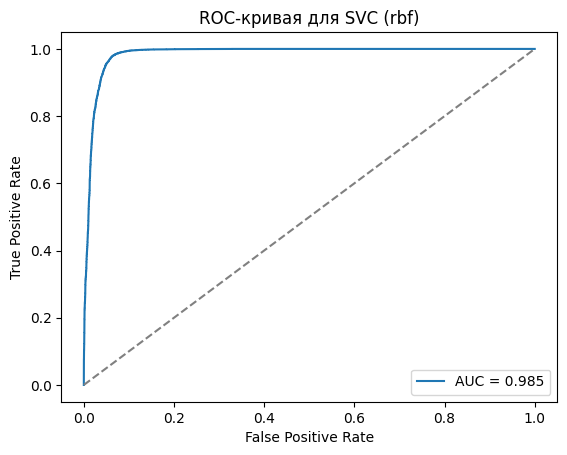

In [33]:
y_prob_svc_rbf = model_svc_rbf.predict_proba(X_test)[:, 1]

fpr_svc_rbf, tpr_svc_rbf, _ = roc_curve(y_test, y_prob_svc_rbf)
roc_auc_svc_rbf = auc(fpr_svc_rbf, tpr_svc_rbf)

plt.figure()
plt.plot(fpr_svc_rbf, tpr_svc_rbf, label=f'AUC = {roc_auc_svc_rbf:.3f}')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая для SVC (rbf)')
plt.legend(loc='lower right')
plt.show()

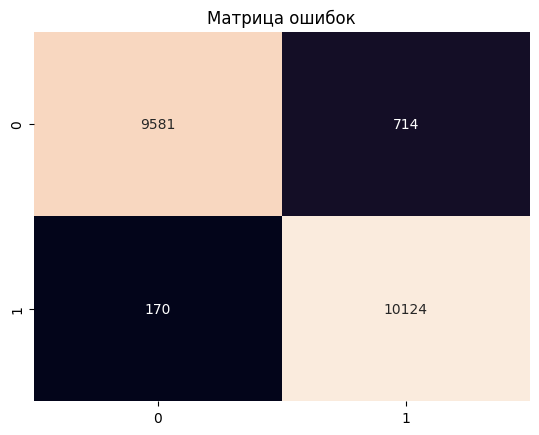

In [34]:
cm_svc_rbf = confusion_matrix(y_test, y_pred_svc_rbf)

plt.figure()
sns.heatmap(cm_svc_rbf, annot=True, fmt='d', cbar=False)
plt.title('Матрица ошибок')
plt.show()

In [35]:
model_svc_rbf = joblib.load(r'models\svc_rbf_model')

SVC(linear) size - 10000 objects

In [36]:
model_svc_linear = SVC(
    C=best_params['SVM']['GridSearchCV']['params']['C'],
    gamma=best_params['SVM']['GridSearchCV']['params']['gamma'],
    kernel='linear',
    probability=True
)
# Hold-out
model_svc_linear.fit(X_train_search, y_train_search)
y_pred_svc_linear = model_svc_linear.predict(X_test)
metrics(y_pred_svc_linear)
# CV
score_svc_linear = cross_val_score(model_svc_linear, X_train_search, y_train_search, cv=2, scoring='accuracy')
print(f'Оценка кросс-валидации: {score_svc_linear.mean()}')

F1: 0.9559129612109745
accuracy: 0.9547331099130604
precision: 0.9315876820947815
recall: 0.9815426462016709
roc_auc_score: 0.9547344119789316
Оценка кросс-валидации: 0.9519137361569847


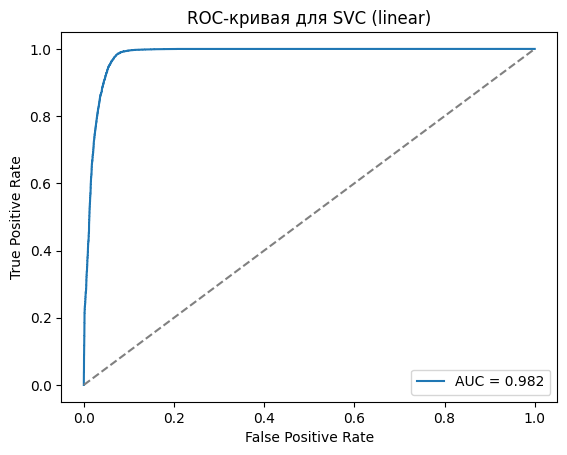

In [37]:
y_prob_svc_linear = model_svc_linear.predict_proba(X_test)[:, 1]

fpr_svc_linear, tpr_svc_linear, _ = roc_curve(y_test, y_prob_svc_linear)
roc_auc_svc_linear = auc(fpr_svc_linear, tpr_svc_linear)

plt.figure()
plt.plot(fpr_svc_linear, tpr_svc_linear, label=f'AUC = {roc_auc_svc_linear:.3f}')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая для SVC (linear)')
plt.legend(loc='lower right')
plt.show()

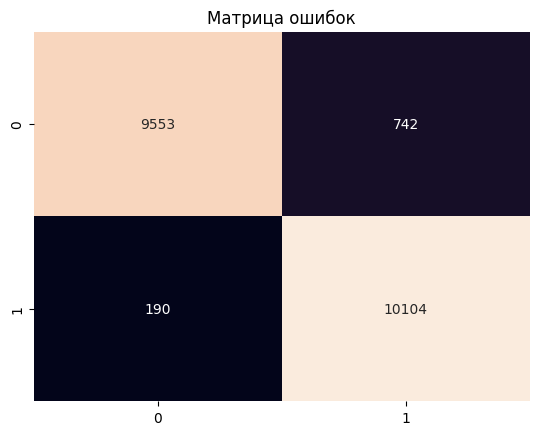

In [38]:
cm_svc_linear = confusion_matrix(y_test, y_pred_svc_linear)

plt.figure()
sns.heatmap(cm_svc_linear, annot=True, fmt='d', cbar=False)
plt.title('Матрица ошибок')
plt.show()

In [39]:
model_svc_linear = joblib.load(r'models\svc_linear_model')

SVC(poly) size - 10000 objects

In [40]:
model_svc_poly = SVC(
    C=best_params['SVM']['GridSearchCV']['params']['C'],
    gamma=best_params['SVM']['GridSearchCV']['params']['gamma'],
    kernel='poly',
    probability=True
)
# Hold-out
model_svc_poly.fit(X_train_search, y_train_search)
y_pred_svc_poly = model_svc_poly.predict(X_test)
metrics(y_pred_svc_poly)
# CV
score_svc_poly = cross_val_score(model_svc_poly, X_train_search, y_train_search, cv=2, scoring='accuracy')
print(f'Оценка кросс-валидации: {score_svc_poly.mean()}')

F1: 0.910670086854777
accuracy: 0.9035892952547476
precision: 0.8483273245577262
recall: 0.9829026617447056
roc_auc_score: 0.9035931472880885
Оценка кросс-валидации: 0.8921701962308141


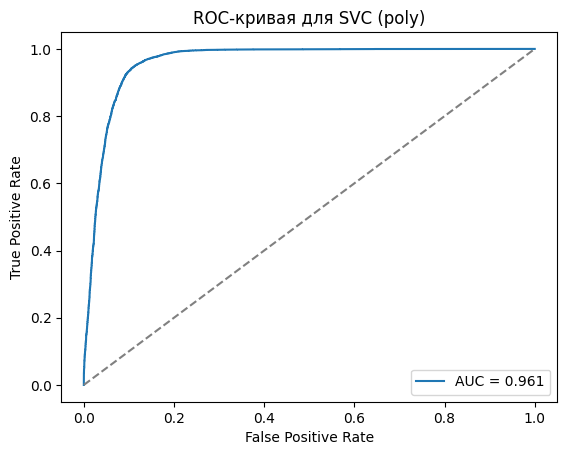

In [41]:
y_prob_svc_poly = model_svc_poly.predict_proba(X_test)[:, 1]

fpr_svc_poly, tpr_svc_poly, _ = roc_curve(y_test, y_prob_svc_poly)
roc_auc_svc_poly = auc(fpr_svc_poly, tpr_svc_poly)

plt.figure()
plt.plot(fpr_svc_poly, tpr_svc_poly, label=f'AUC = {roc_auc_svc_poly:.3f}')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая для SVC (poly)')
plt.legend(loc='lower right')
plt.show()

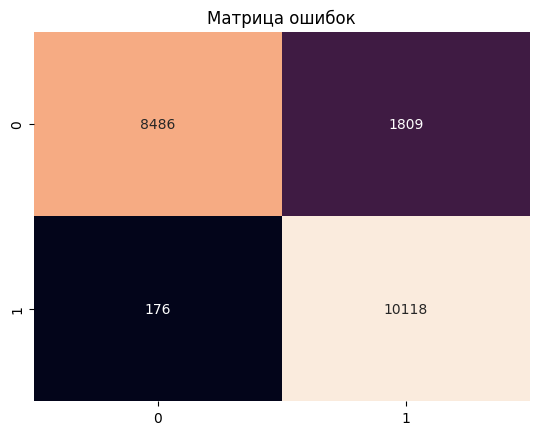

In [42]:
cm_svc_poly = confusion_matrix(y_test, y_pred_svc_poly)

plt.figure()
sns.heatmap(cm_svc_poly, annot=True, fmt='d', cbar=False)
plt.title('Матрица ошибок')
plt.show()

In [43]:
model_svc_poly = joblib.load(r'models/svc_poly_model')

SVC(sigmoid) size - 10000 object

In [44]:
model_svc_sigmoid = SVC(
    C=best_params['SVM']['GridSearchCV']['params']['C'],
    gamma=best_params['SVM']['GridSearchCV']['params']['gamma'],
    kernel='sigmoid',
    probability=True
)
# Hold-out
model_svc_sigmoid.fit(X_train_search, y_train_search)
y_pred_svc_sigmoid = model_svc_sigmoid.predict(X_test)
metrics(y_pred_svc_sigmoid)
# CV
score_svc_sigmoid = cross_val_score(model_svc_sigmoid, X_train_search, y_train_search, cv=2, scoring='accuracy')
print(f'Оценка кросс-валидации: {score_svc_sigmoid.mean()}')

F1: 0.9345776409467
accuracy: 0.933945310602749
precision: 0.9256718124642653
recall: 0.9436564989314163
roc_auc_score: 0.9339457822486127
Оценка кросс-валидации: 0.9360792694773654


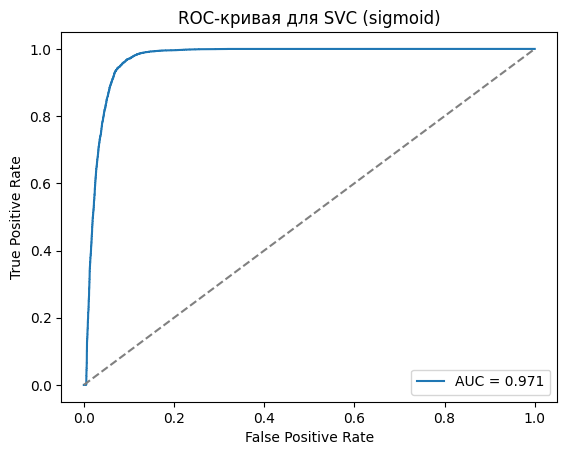

In [45]:
y_prob_svc_sigmoid = model_svc_sigmoid.predict_proba(X_test)[:, 1]

fpr_svc_sigmoid, tpr_svc_sigmoid, _ = roc_curve(y_test, y_prob_svc_sigmoid)
roc_auc_svc_sigmoid = auc(fpr_svc_sigmoid, tpr_svc_sigmoid)

plt.figure()
plt.plot(fpr_svc_sigmoid, tpr_svc_sigmoid, label=f'AUC = {roc_auc_svc_sigmoid:.3f}')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая для SVC (sigmoid)')
plt.legend(loc='lower right')
plt.show()

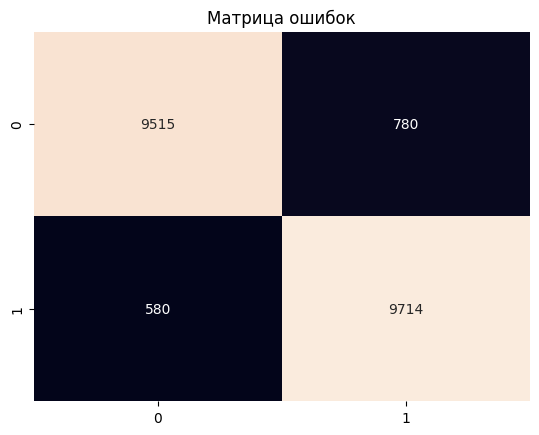

In [46]:
cm_svc_sigmoid = confusion_matrix(y_test, y_pred_svc_sigmoid)

plt.figure()
sns.heatmap(cm_svc_sigmoid, annot=True, fmt='d', cbar=False)
plt.title('Матрица ошибок')
plt.show()

In [47]:
model_svc_sigmoid = joblib.load(r'models\svc_sigmoid_model')

SVC(precomputed) size - 10000 objects

In [48]:
model_svc_precomputed = SVC(
    C=best_params['SVM']['GridSearchCV']['params']['C'],
    gamma=best_params['SVM']['GridSearchCV']['params']['gamma'],
    kernel='precomputed',
    probability=True
)
# Hold-out
prec_train = np.dot(X_train_search, X_train_search.T)
prec_test = np.dot(X_test, X_train_search.T)
model_svc_precomputed.fit(prec_train, y_train_search)
y_pred_svc_precomputed = model_svc_precomputed.predict(prec_test)
metrics(y_pred_svc_precomputed)
# CV
score_svc_precomputed = cross_val_score(model_svc_precomputed, prec_train, y_train_search, cv=2, scoring='accuracy')
print(f'Оценка кросс-валидации: {score_svc_precomputed.mean()}')

F1: 0.9559129612109745
accuracy: 0.9547331099130604
precision: 0.9315876820947815
recall: 0.9815426462016709
roc_auc_score: 0.9547344119789316
Оценка кросс-валидации: 0.9519137361569847


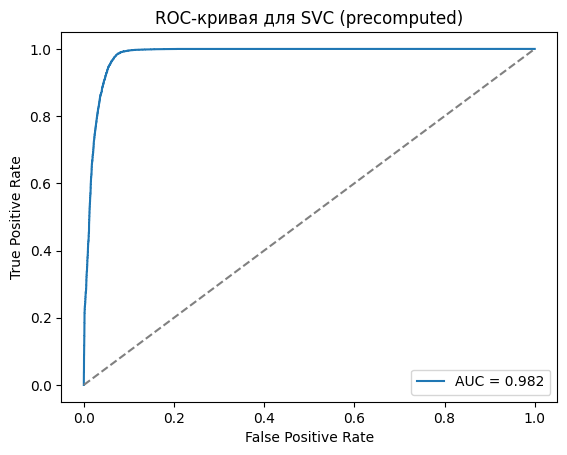

In [49]:
y_prob_svc_precomputed = model_svc_precomputed.predict_proba(prec_test)[:, 1]

fpr_svc_precomputed, tpr_svc_precomputed, _ = roc_curve(y_test, y_prob_svc_precomputed)
roc_auc_svc_precomputed = auc(fpr_svc_precomputed, tpr_svc_precomputed)

plt.figure()
plt.plot(fpr_svc_precomputed, tpr_svc_precomputed, label=f'AUC = {roc_auc_svc_precomputed:.3f}')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая для SVC (precomputed)')
plt.legend(loc='lower right')
plt.show()

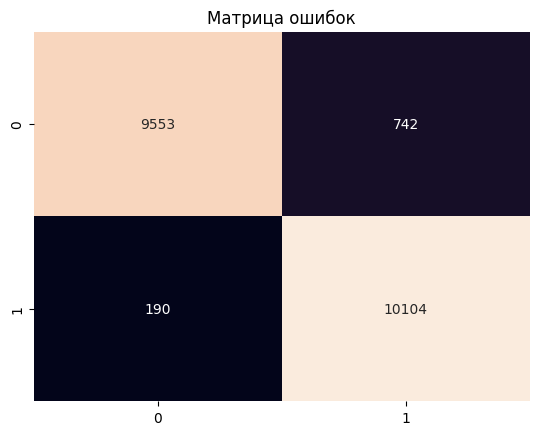

In [50]:
cm_svc_precomputed = confusion_matrix(y_test, y_pred_svc_precomputed)

plt.figure()
sns.heatmap(cm_svc_precomputed, annot=True, fmt='d', cbar=False)
plt.title('Матрица ошибок')
plt.show()

In [51]:
model_svc_precomputed = joblib.load(r'models\svc_precomputed_model')

In [52]:
saved_models = {model_lr: model_lr.predict(X_test),
                model_knn: model_knn.predict(X_test),
                model_nb: model_nb.predict(X_test),
                model_svc_linear: model_svc_linear.predict(X_test),
                model_svc_poly: model_svc_poly.predict(X_test),
                model_svc_linear: model_svc_linear.predict(X_test),
                model_svc_precomputed: model_svc_precomputed.predict(prec_test),
                model_svc_sigmoid: model_svc_sigmoid.predict(X_test)
                }
metrics_for_model = [accuracy_score, f1_score, recall_score, precision_score, roc_auc_score]

result = {}

for model, y_pred in saved_models.items():
    result[f'{model}'] = {}
    for metric in metrics_for_model:
        result[f'{model}']['accuracy'] = accuracy_score(y_true=y_test, y_pred=y_pred)
        result[f'{model}']['f1'] = f1_score(y_true=y_test, y_pred=y_pred)
        result[f'{model}']['recall'] = recall_score(y_true=y_test, y_pred=y_pred)
        result[f'{model}']['precision'] = precision_score(y_true=y_test, y_pred=y_pred)
        result[f'{model}']['roc_auc'] = roc_auc_score(y_true=y_test, y_score=y_pred)

In [53]:
df = pd.DataFrame.from_dict(result, orient='index')
df

,accuracy,f1,recall,precision,roc_auc
"LogisticRegression(C=1, max_iter=10000, penalty='l1', solver='liblinear',\n tol=0.001)",0.952790,0.953745,0.973480,0.934795,0.952791
"KNeighborsClassifier(metric='manhattan', n_neighbors=9, weights='distance')",0.949925,0.951494,0.982320,0.922544,0.949926
GaussianNB(),0.917626,0.919061,0.935399,0.903283,0.917627
"SVC(C=10, gamma=0.01, kernel='linear', probability=True)",0.955705,0.956949,0.984651,0.930762,0.955706
"SVC(C=10, gamma=0.01, kernel='poly', probability=True)",0.905484,0.912516,0.985914,0.849289,0.905487
"SVC(C=10, gamma=0.01, kernel='precomputed', probability=True)",0.843314,0.846906,0.866816,0.827890,0.843316
"SVC(C=10, gamma=0.01, kernel='sigmoid', probability=True)",0.933362,0.934007,0.943171,0.925019,0.933363


In [54]:
# Лучшая модель

best_model_accuracy = df['accuracy'].idxmax()
best_model_f1 = df['f1'].idxmax()
best_model_reccall = df['recall'].idxmax()
best_model_precision = df['precision'].idxmax()
best_model_roc_auc = df['roc_auc'].idxmax()

best_models = {
    'accuracy': best_model_accuracy,
    'f1': best_model_f1,
    'recall': best_model_reccall,
    'precision': best_model_precision,
    'roc_auc': best_model_roc_auc
}

best_scores = {
    metric: df.loc[model, metric]
    for metric, model in best_models.items()
}

summary = pd.DataFrame({
    'best_model': best_models,
    'best_score': best_scores
})
summary

,best_model,best_score
accuracy,"SVC(C=10, gamma=0.01, kernel='linear', probabi...",0.955705
f1,"SVC(C=10, gamma=0.01, kernel='linear', probabi...",0.956949
recall,"SVC(C=10, gamma=0.01, kernel='poly', probabili...",0.985914
precision,"LogisticRegression(C=1, max_iter=10000, penalt...",0.934795
roc_auc,"SVC(C=10, gamma=0.01, kernel='linear', probabi...",0.955706


# Вывод

Практический по всем метрикам модель опорных векторов с ядром 'linear' является лучше, следовательно для данной выборки лучшей моделью будет SVC (kernel='linear')